In [ ]:
from fastspeech.modules import *
from fastspeech.data import *
from fastspeech.training import *
from fastspeech.visualize import *
from fastspeech.preprocess import ZScoreNormalization, MinMaxNormalization, NoNorm
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn.functional as F
from functools import partial
from pathlib import Path
import json
import torch

In [ ]:
path = Path("../../data/LJSpeech-1.1/wavs/")
path_vocab = Path("../../data/CMUDict/cmudict-0.7b.symbols.txt")
path_stats = Path("../sample_data/lj_mel_stats.json")

In [ ]:
with open(path_stats, 'r') as f: stats = json.load(f)

In [ ]:
stats = {key: float(stats[key]) for key in stats}
stats["top_db"] = 35
stats

{'min_val': -0.000100009995,
 'max_val': 12.625555,
 'mean': 0.0021890362,
 'std': 0.02285596,
 'top_db': 35}

In [ ]:
cut = int(13084*.9)
ds = TTSDataset(path, path_vocab, ZScoreNormalization, ds=slice(0, cut), 
                preload=True, stats=stats)
ds_v = TTSDataset(path, path_vocab, ZScoreNormalization, ds=slice(cut, None), 
                preload=True, stats=stats)

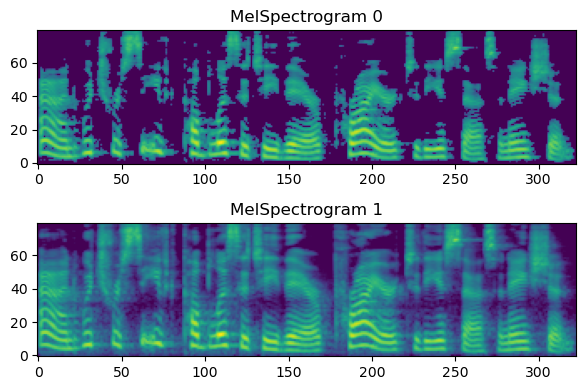

In [ ]:
normalized = ds.mels[0]
denormalized = ds.norm.denormalize(normalized)
show_mels([normalized, denormalized])

In [ ]:
bs = 48
n_workers = 2
pres_worker = True

collate_fn_p = partial(collate_fn, pad_num=ds.vocab.pad_num, norm=ds.norm)
dl = DataLoader(ds, bs, shuffle=True, num_workers=n_workers, pin_memory=True,
                collate_fn=collate_fn_p, persistent_workers=pres_worker)
dl_v = DataLoader(ds_v, bs, shuffle=True, num_workers=n_workers, pin_memory=True,
                collate_fn=collate_fn_p, persistent_workers=pres_worker)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
hs, no = 256, 80
log_interval = 500
clip = 5.
steps = 500000

config = {
    "model": {
        "embedding_size": len(ds.vocab.vocab), "hidden_size": hs, "num_bins": no, 
        "num_encoders": 4, "num_decoders": 4,
        "encoder": {
            "hidden_size": hs,
            "multi_head_attention": {"hidden_size": hs, "num_attention_heads": 2,
                                     "hidden_dropout_prob": 0.1},
            "conv_net": {"hidden_size": hs, "kernal_sizes": [9,1], "filter_size": 1024,
                         "hidden_dropout_prob": 0.1}
        },
        "decoder": {
            "hidden_size": hs,
            "multi_head_attention": {"hidden_size": hs, "num_attention_heads": 2,
                                     "hidden_dropout_prob": 0.1},
            "conv_net": {"hidden_size": hs, "kernal_sizes": [9,1], "filter_size": 1024,
                         "hidden_dropout_prob": 0.1}
        },
        "duration_predictor": {"hidden_size": hs, "kernal_sizes": [3,3], "filter_size": hs,
                               "hidden_dropout_prob": 0.5},
#         "postnet": {"hidden_size": no, "kernal_size": 5, "filter_size": 512, 
#                     "hidden_dropout_prob": 0.5, "num_layers": 5},
    },
    "optim": {"lr":  1e-4, "betas": (0.9, 0.98), "eps": 1e-10, "weight_decay": 0.},
    "scheduler": {"lr_mul": 1., "d_model": hs, "n_warmup_steps": 4000},
#     "scheduler": {"max_lr": 1e-4, "total_steps": steps},
}
learner = FastspeechLearner(dl, ds.norm, FastSpeech, Adam, TransformerScheduler, 
                            config, mae_loss, F.mse_loss, mae_loss, fp_16=False, 
                            dl_v=dl_v, grad_clip=clip, device=device, 
                            log_interval=log_interval)

In [ ]:
count_parameters(learner.model)

23532881

In [ ]:
file_path = "../checkpoints/save_84.pt"
checkpoint_steps = 42500
state_dict, config, norm = load_checkpoint(file_path)
learner.load_model_state_dict(state_dict)
learner.scheduler.n_steps = checkpoint_steps
steps = steps - checkpoint_steps

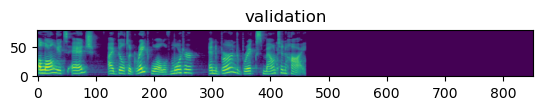

Training:   0%|          | 0/457500 [00:00<?, ?step/s]

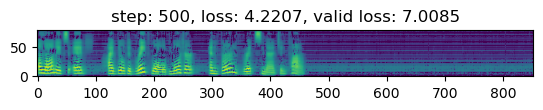

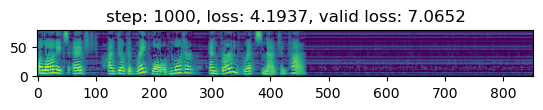

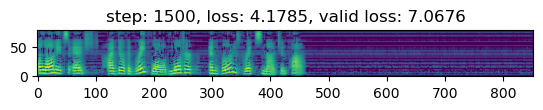

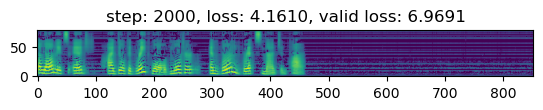

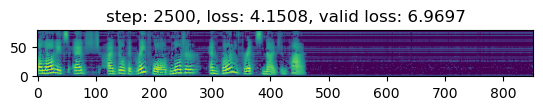

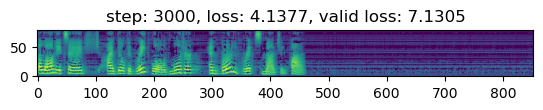

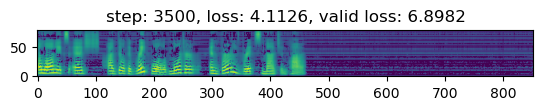

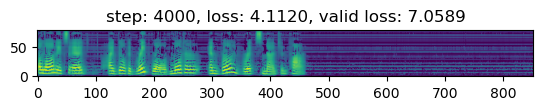

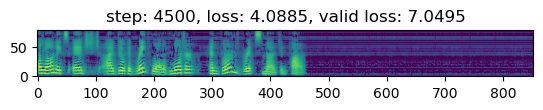

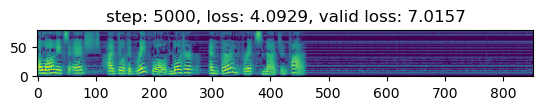

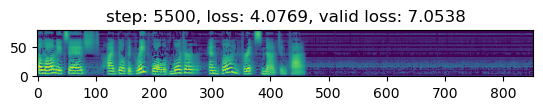

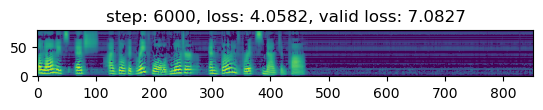

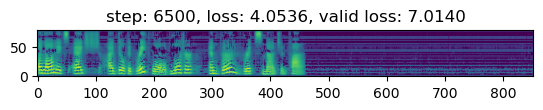

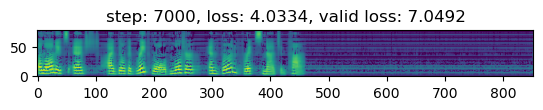

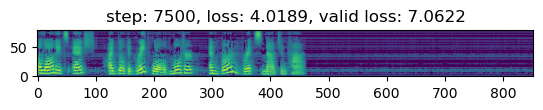

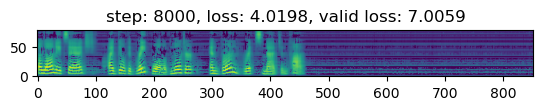

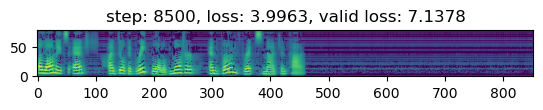

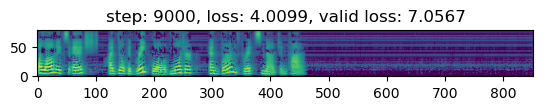

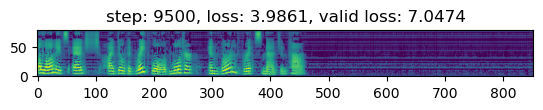

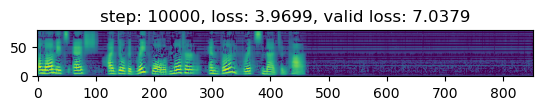

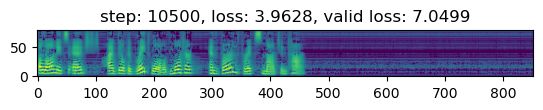

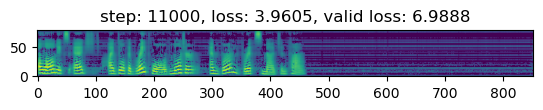

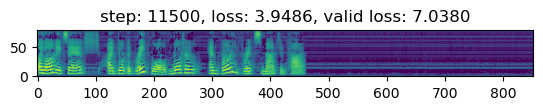

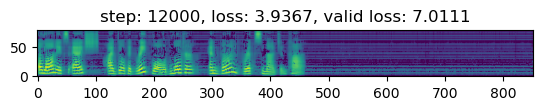

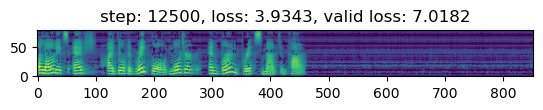

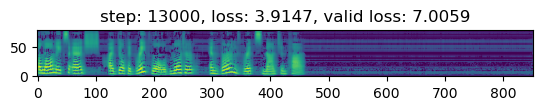

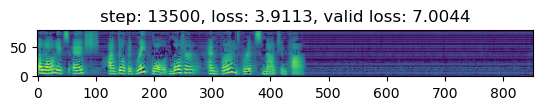

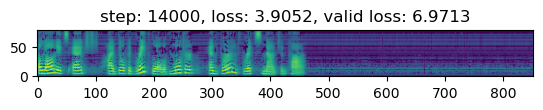

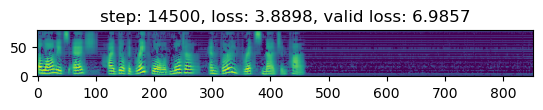

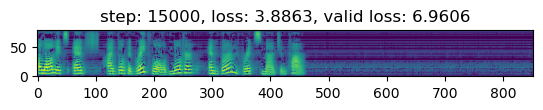

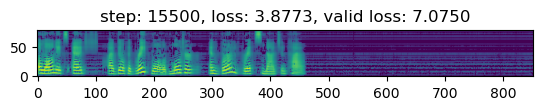

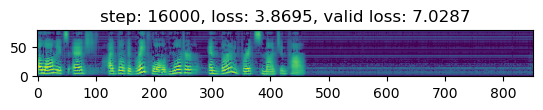

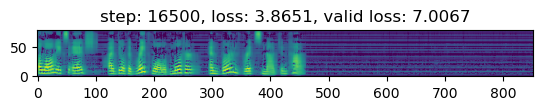

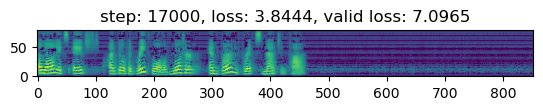

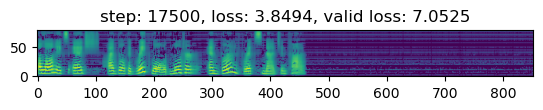

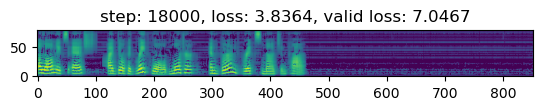

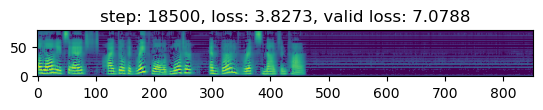

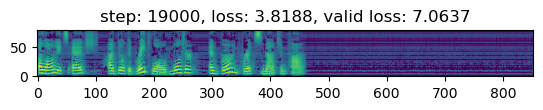

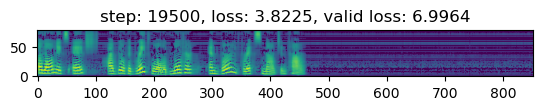

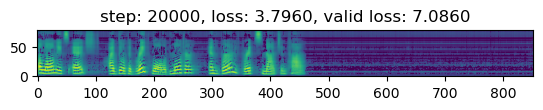

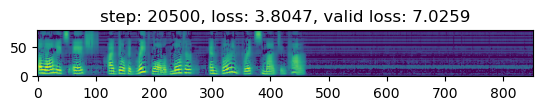

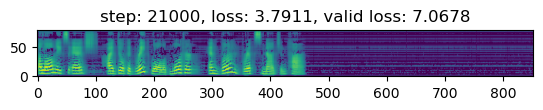

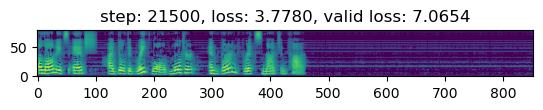

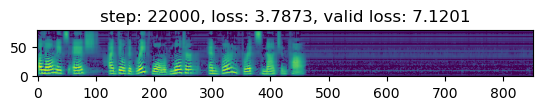

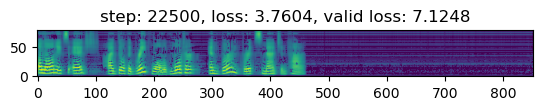

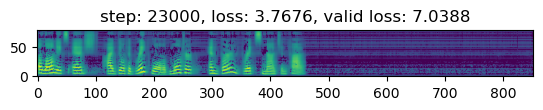

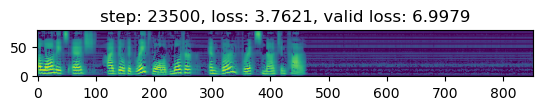

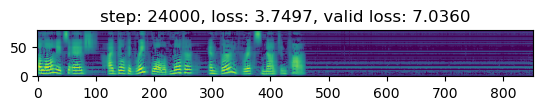

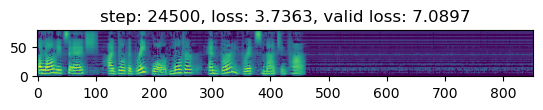

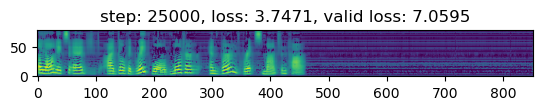

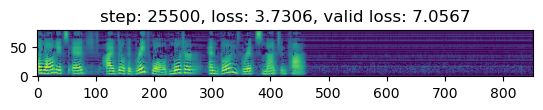

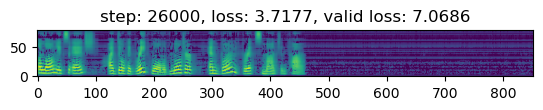

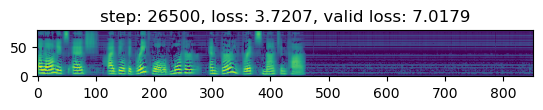

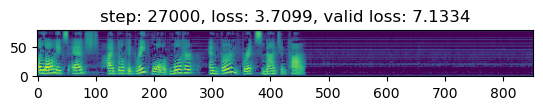

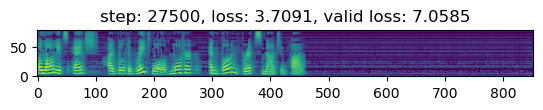

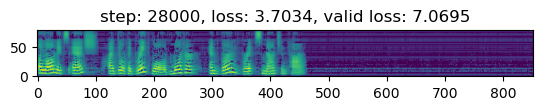

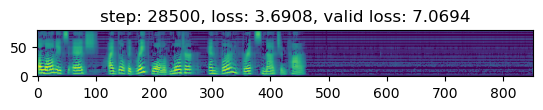

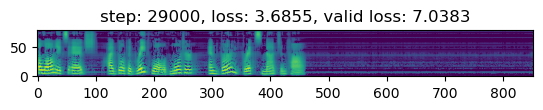

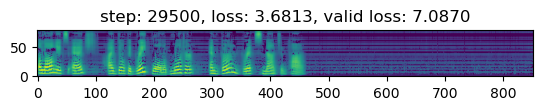

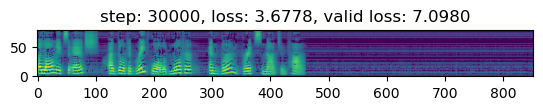

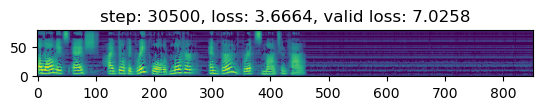

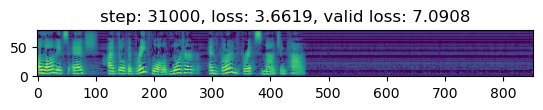

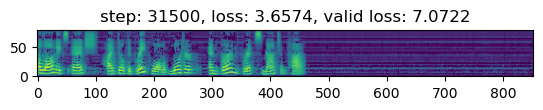

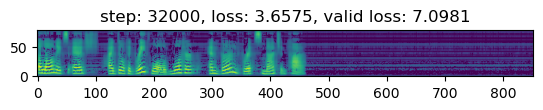

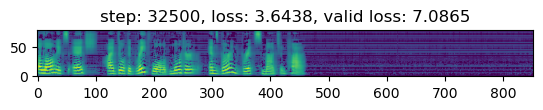

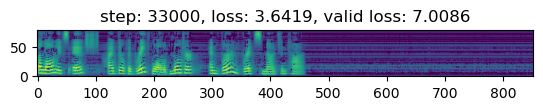

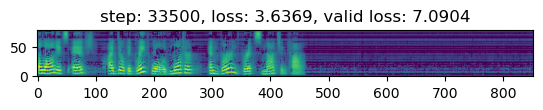

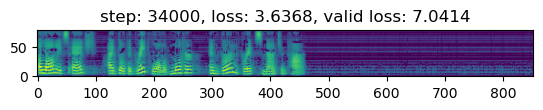

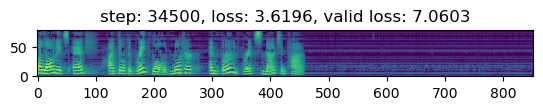

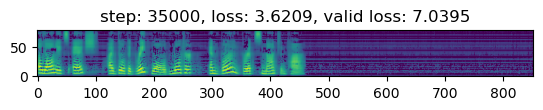

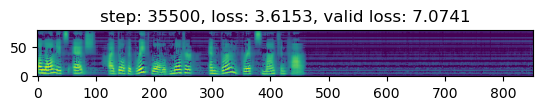

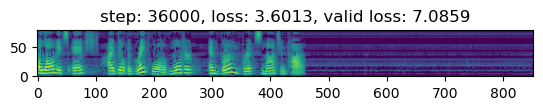

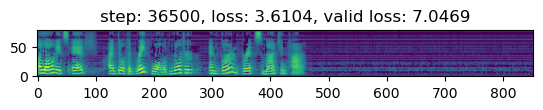

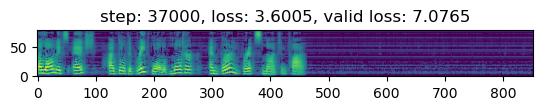

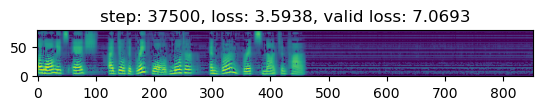

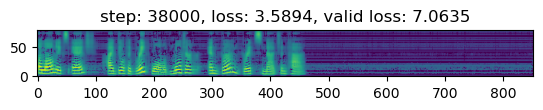

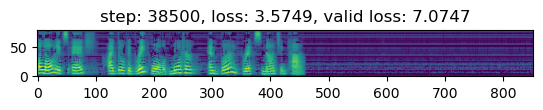

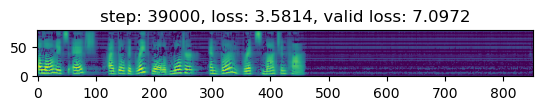

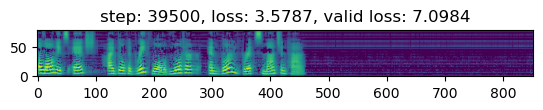

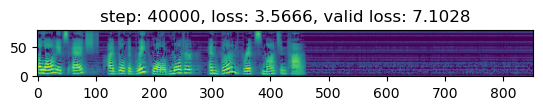

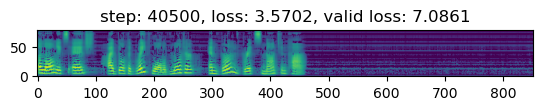

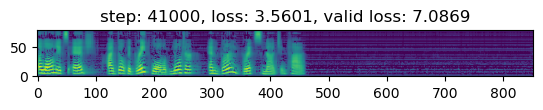

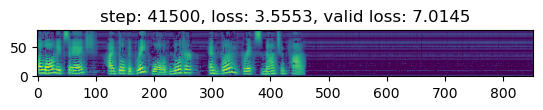

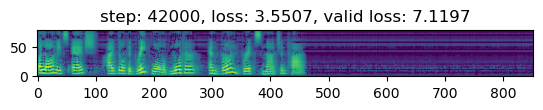

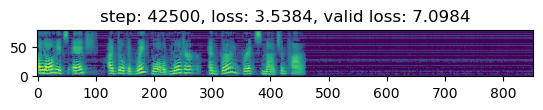

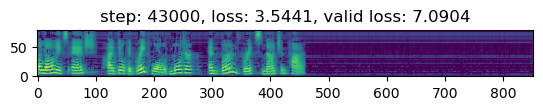

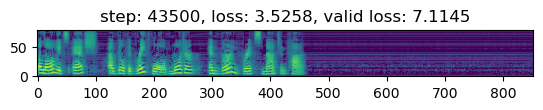

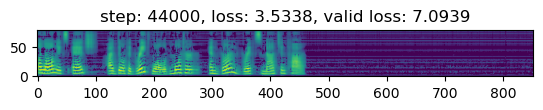

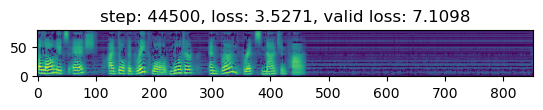

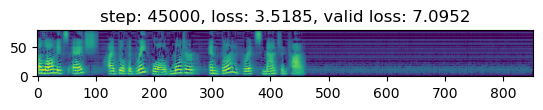

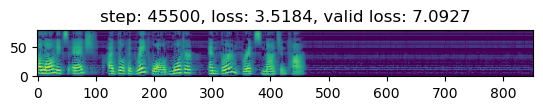

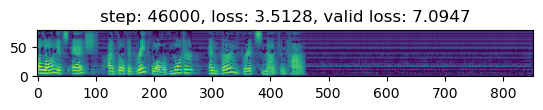

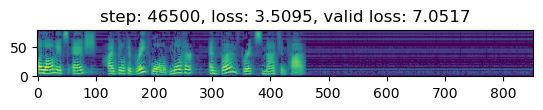

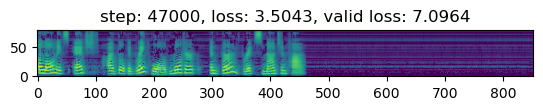

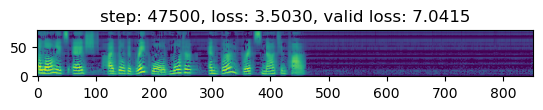

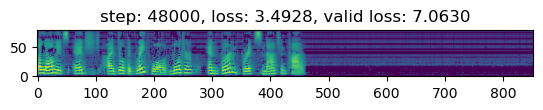

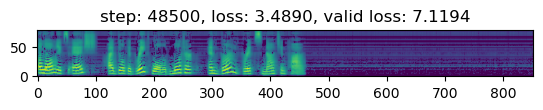

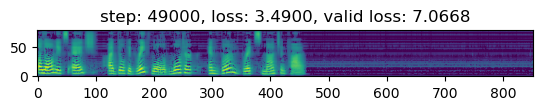

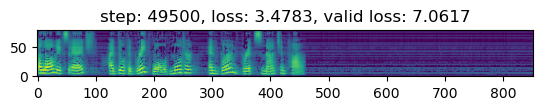

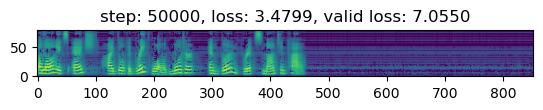

In [ ]:
learner.fit(steps)

In [ ]:
plot_loss(learner.loss_history['a'])

In [ ]:
plot_loss(learner.loss_valid_history['a'], 'validation')

In [ ]:
mels = list(map(lambda x: x[0], learner.mel_history))